Importing the libraries

In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
import torch
import torchvision as vision
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

Preprocess datasets and upload them into image, label folders

In [3]:
# Assuming images are in a folder named "dataset" and labeled by subfolders
def load_images_from_folder(folder):
    images = []
    labels = []
    label = 0

    for subdir in os.listdir(folder):
        subfolder = os.path.join(folder, subdir)
        if os.path.isdir(subfolder):
            for filename in os.listdir(subfolder):
                img_path = os.path.join(subfolder, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    
                    img = cv2.resize(img, (224,224)) # resized the images from 128x128 to 224x224 so that ResNet can take them
                    images.append(img)
                    labels.append(label) # you can append(subdir) if you want to have string labels
            label += 1
    return images, labels

images, labels = load_images_from_folder("Dataset")


# Split the data into training and testing sets
x_train, x_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.5, random_state=42, stratify=labels)

# Split the temporary set into validation and test sets
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# converting our lists to np arrays
x_train, x_val, x_test, y_train, y_val, y_test = np.array(x_train,dtype=float), np.array(x_val,dtype=float), np.array(x_test,dtype=float), np.array(y_train,dtype=float), np.array(y_val,dtype=float), np.array(y_test,dtype=float)

# we know have lists of np arrays x_train y_train, x_val y_val, x_test y_test (train 
# for i in range(len(x_train)): # seeing images and labels in training dataset
#     print (x_train[i])
#     print (y_train[i])
# 
# print(len(images), len(labels)) # making sure all images have attached labels
# print(len(x_train), len(x_val), len(x_test))
# print(len(y_train), len(y_val), len(y_test))

Create a train, val, test dataloader so that we can iterate through the dataset with pytorch! (and use other features like shuffle, batch etc)

In [3]:
# Convert data to PyTorch tensors and ensure they are of type float
x_train_tensor = torch.tensor(x_train).unsqueeze(1).float()  # Add channel dimension and convert to float
x_val_tensor = torch.tensor(x_val).unsqueeze(1).float()      # Add channel dimension and convert to float
x_test_tensor = torch.tensor(x_test).unsqueeze(1).float()    # Add channel dimension and convert to float

y_train_tensor = torch.tensor(y_train).long()
y_val_tensor = torch.tensor(y_val).long()
y_test_tensor = torch.tensor(y_test).long()

# Create TensorDataset
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoader
batch_size = 64  # You can adjust the batch size

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Now, you can use train_loader, val_loader, and test_loader in your training loop


Fine-tune ResNet18

In [4]:
# define the model

# Load the pre-trained ResNet-18 model
weights = models.ResNet18_Weights.IMAGENET1K_V1
resnet18 = models.resnet18(weights=weights)

# Ensure the model is in the correct mode
resnet18 = resnet18.float()
 
# Adjust the first convolutional layer
# Original first conv layer: 3 input channels, here we change it to 1
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Freeze all layers
for param in resnet18.parameters():
    param.requires_grad = False

# Unfreeze the last block of convolutions (layer4) and the final fully connected layer
for param in resnet18.layer4.parameters(): # layer for is second to last fully connected layer name in ResNet18
    param.requires_grad = True
for param in resnet18.fc.parameters():
    param.requires_grad = True

# Adjust the final fully connected layer for 4 classes
num_ftrs = resnet18.fc.in_features # finding how many in_features the last layer has so we can create a new onw with a new out_channel number
resnet18.fc = nn.Linear(num_ftrs, 4)

Define a loss function and an optimizer (cross entropy loss and adam)

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([
    {'params': resnet18.layer4.parameters()},
    {'params': resnet18.fc.parameters()}
], lr=0.001)

Create a training loop (we are not using this one right now)

In [6]:
# num_epochs = 10
# 
# 
# for epoch in range(num_epochs):
#     resnet18.train()  # Set the model to training mode
#     total_loss = 0
#     num_batches = 0
# 
#     for inputs, labels in train_loader:
#         optimizer.zero_grad()
# 
#         # Forward pass
#         outputs = resnet18(inputs)
#         loss = criterion(outputs, labels)
# 
#         # Backward pass and optimize
#         loss.backward()
#         optimizer.step()
# 
#         total_loss += loss.item()  # Accumulate the loss
#         num_batches += 1
# 
#     average_loss = total_loss / num_batches
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

    # Validation step (optional but recommended)
    # ...


Training/Validation loop

100%|██████████| 25/25 [00:43<00:00,  1.75s/it]


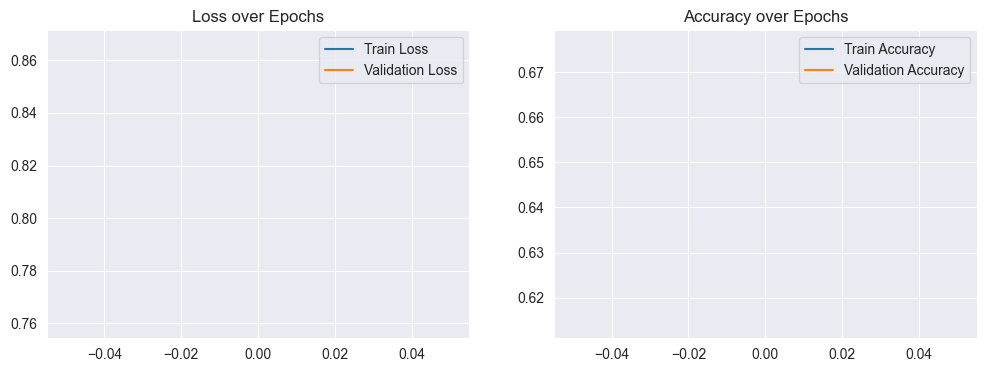

100%|██████████| 25/25 [00:46<00:00,  1.87s/it]


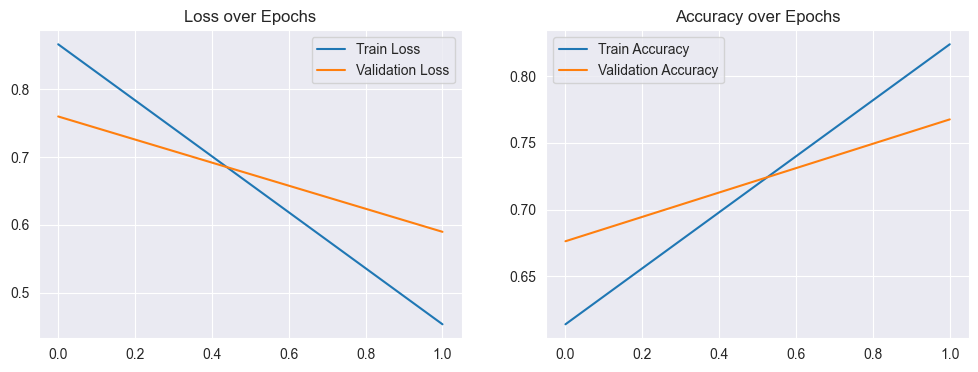

100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


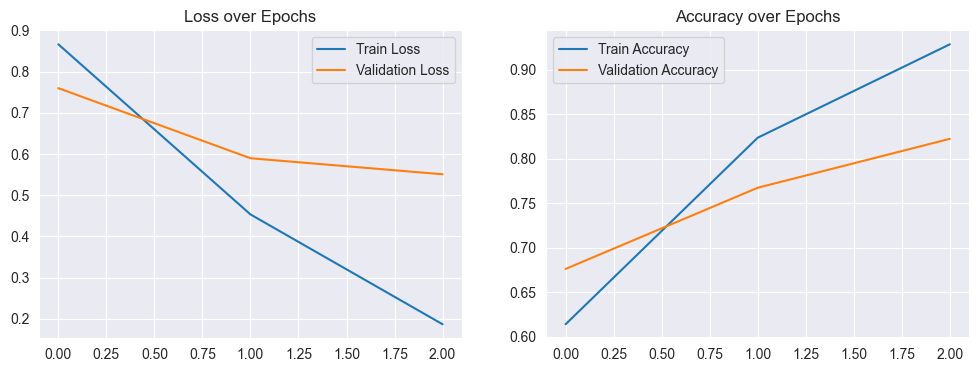

100%|██████████| 25/25 [00:39<00:00,  1.59s/it]


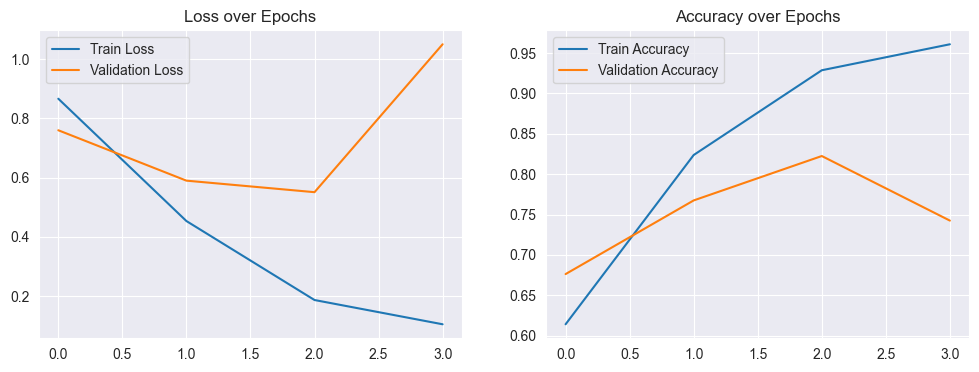

100%|██████████| 25/25 [00:45<00:00,  1.82s/it]


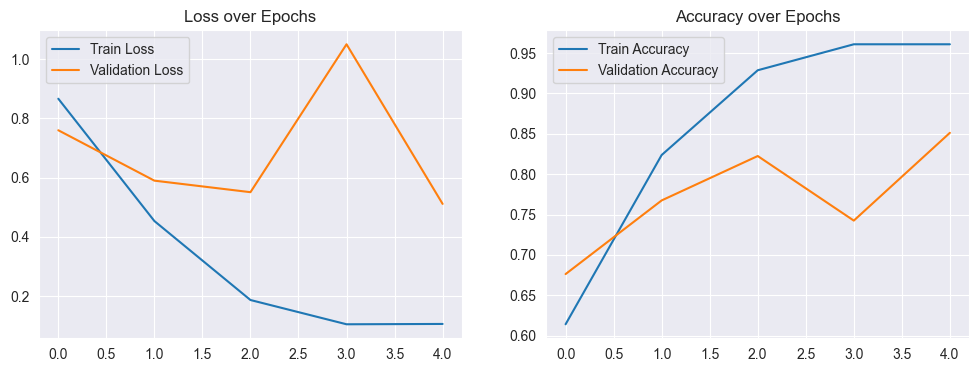

100%|██████████| 25/25 [00:40<00:00,  1.62s/it]


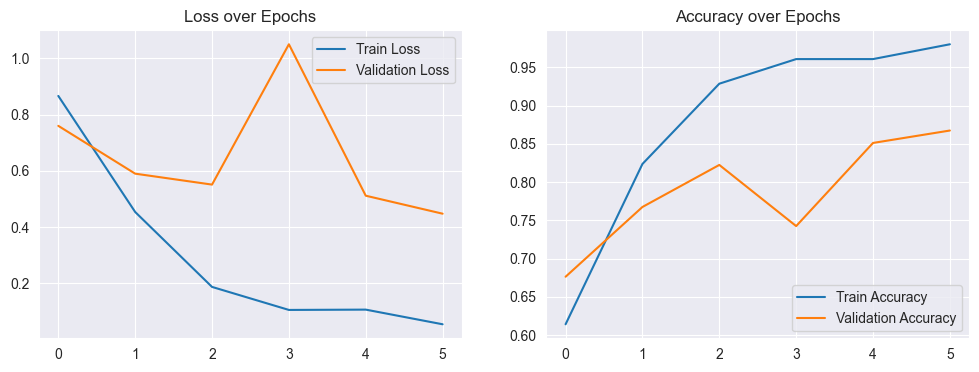

100%|██████████| 25/25 [00:43<00:00,  1.76s/it]


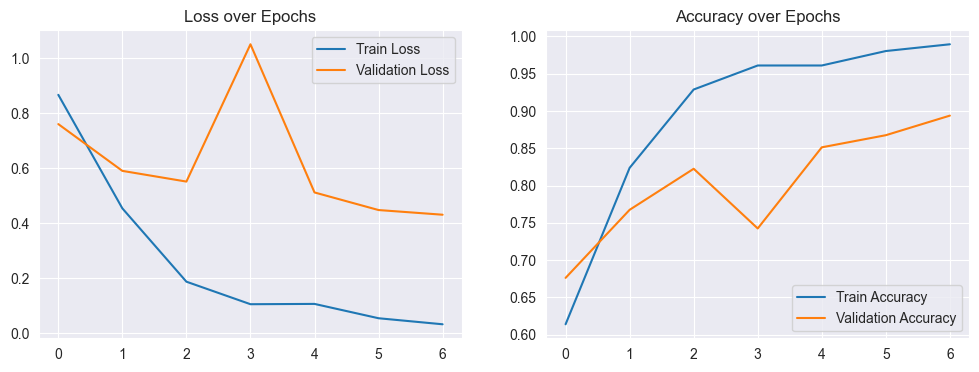

100%|██████████| 25/25 [01:14<00:00,  2.98s/it]


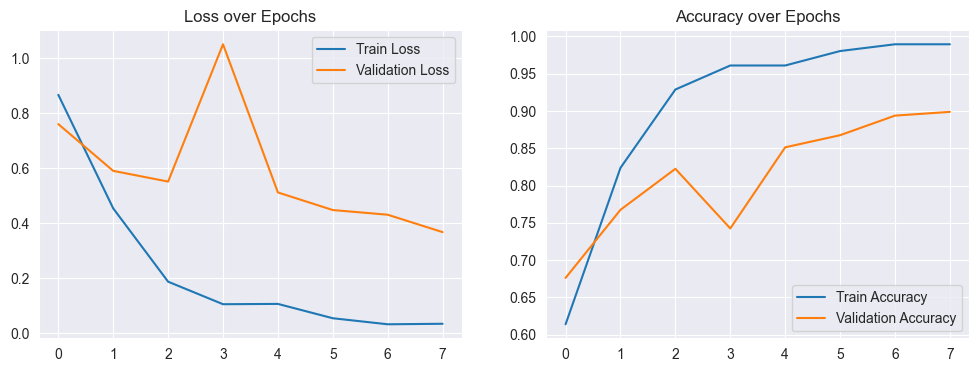

In [7]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score, accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bars

num_epochs = 8

# Initialize lists to store metrics for plotting later
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_f1_scores, val_f1_scores = [], []

for epoch in range(num_epochs):
    # Training Phase
    resnet18.train()
    total_loss, total_correct, total = 0, 0, 0
    predictions, true_labels = [], []

    # Loop over each batch from the training set
    for inputs, labels in tqdm(train_loader):
        optimizer.zero_grad() # Zero the gradients
        
        outputs = resnet18(inputs) # Forward pass: Compute predicted outputs by passing inputs to the model
        
        loss = criterion(outputs, labels) # Calculate the loss
        loss.backward() # Backward pass: Compute gradient of the loss with respect to model parameters
        optimizer.step() # Perform a single optimization step (parameter update)

        total_loss += loss.item() # Record the loss
        
        _, predicted = torch.max(outputs, 1) # Convert outputs probabilities to predicted class
        
        # Record the correct predictions for accuracy calculation
        total_correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Extend the predictions list for F1 score calculation
        predictions.extend(predicted.view(-1).tolist())
        true_labels.extend(labels.view(-1).tolist())

    # Calculate and store accuracy and F1 score
    train_accuracy = total_correct / total
    train_f1 = f1_score(true_labels, predictions, average='weighted')
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(train_accuracy)
    train_f1_scores.append(train_f1)

    # Validation Phase
    resnet18.eval()  # Set the model to evaluation mode
    total_val_loss, total_val_correct, total_val = 0, 0, 0
    val_predictions, val_true_labels = [], []

    # Disable gradient calculation for efficiency
    with torch.no_grad():
        # Loop over each batch from the validation set
        for val_inputs, val_labels in tqdm(val_loader):
            # Forward pass: Compute predicted outputs by passing inputs to the model
            val_outputs = resnet18(val_inputs)

            # Calculate the loss
            val_loss = criterion(val_outputs, val_labels)

            # Record the loss
            total_val_loss += val_loss.item()

            # Convert outputs probabilities to predicted class
            _, val_predicted = torch.max(val_outputs, 1)

            # Record the correct predictions for accuracy calculation
            total_val_correct += (val_predicted == val_labels).sum().item()
            total_val += val_labels.size(0)

            # Extend the predictions list for F1 score calculation
            val_predictions.extend(val_predicted.view(-1).tolist())
            val_true_labels.extend(val_labels.view(-1).tolist())

    # Calculate and store accuracy and F1 score
    val_accuracy = total_val_correct / total_val
    val_f1 = f1_score(val_true_labels, val_predictions, average='weighted')
    val_losses.append(total_val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)

    # Plotting the loss and accuracy after each epoch
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.show()

# Plot the Confusion Matrix for the Validation Set
cm = confusion_matrix(val_true_labels, val_predictions)



[0.7596726608276367, 0.5896358227729798, 0.5507308328151703, 1.0497855401039125, 0.5112322413921356, 0.44726440608501433, 0.4302775591611862, 0.36701280653476714] [0.67625, 0.7675, 0.8225, 0.7425, 0.85125, 0.8675, 0.89375, 0.89875] [0.6823953869204041, 0.7653868119790331, 0.8172583090011741, 0.7206724288241938, 0.8449606548463087, 0.8695393810354196, 0.8916807662312443, 0.8984024141918878]
[[173   0   9  42]
 [  2  11   0   3]
 [  5   0 742  53]
 [  3   0  45 512]]


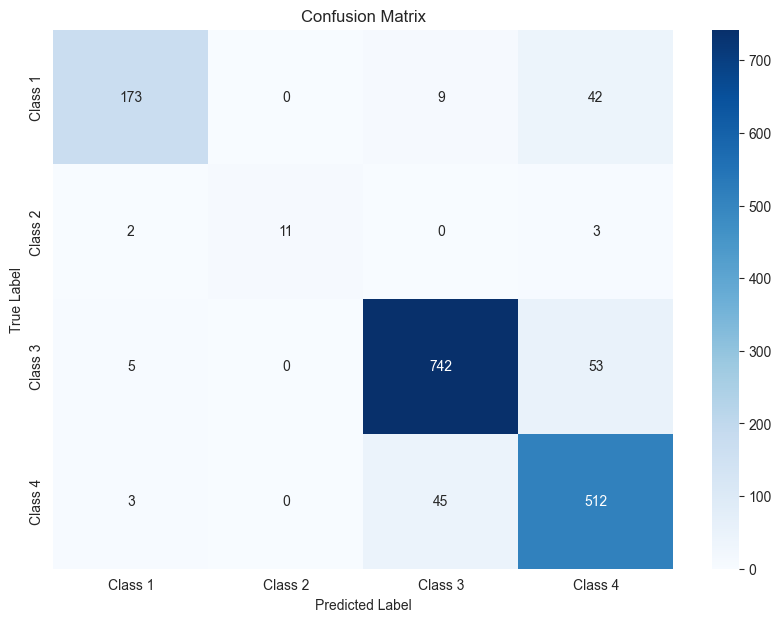

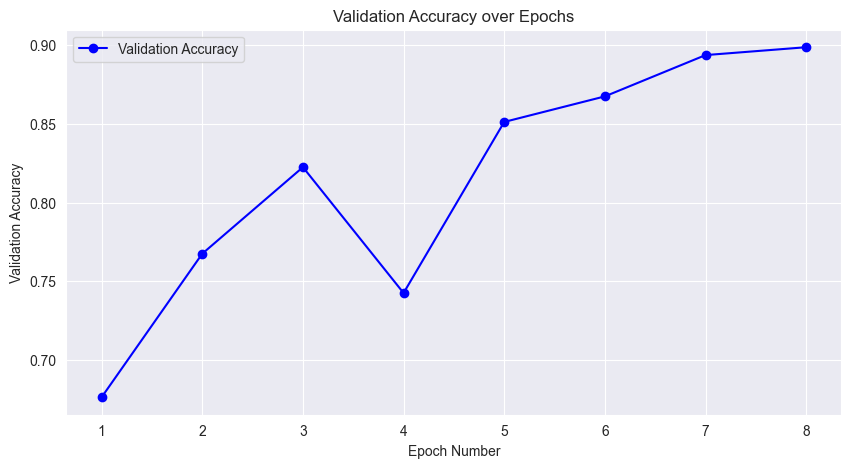

In [8]:
print(val_losses, val_accuracies, val_f1_scores )

import seaborn as sns


# Assuming val_true_labels and val_predictions are the true labels and predictions from your validation set
cm = confusion_matrix(val_true_labels, val_predictions)

# Print the confusion matrix as is
print(cm)

# For a nicer display, you can use Seaborn's heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4'], yticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


# Assuming val_accuracies is a list containing the validation accuracies for each epoch
# And assuming you have the same number of epochs as the length of the val_accuracies list
epochs = list(range(1, len(val_accuracies) + 1))

plt.figure(figsize=(10, 5))
plt.plot(epochs, val_accuracies, marker='o', linestyle='-', color='blue', label='Validation Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch Number')
plt.ylabel('Validation Accuracy')
plt.xticks(epochs)  # This ensures that only whole numbers are used as epoch markers
plt.legend()
plt.grid(True)
plt.show()

Test your model!

In [9]:

# Put model in evaluation model
resnet18.eval()

# Initialize lists to hold the true labels and predictions
test_predictions = []
test_true_labels = []

# No gradient tracking needed
with torch.no_grad():
    # Initialize the loss and correct predictions count
    test_loss = 0
    correct_predictions = 0

    # Loop over the test data
    for inputs, labels in tqdm(test_loader):
        # Forward pass - compute predictions
        outputs = resnet18(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Convert output probabilities to predicted class
        _, preds = torch.max(outputs, 1)

        # Record the correct predictions
        correct_predictions += (preds == labels).sum().item()

        # Append the predictions and true labels for further analysis
        test_predictions.extend(preds.view(-1).tolist())  # view(-1) flattens the tensor into a 1D tensor, no matter the initial row and column count, in our case it already is 1D because preds = indices with the highest probability output
        test_true_labels.extend(labels.view(-1).tolist())

# Calculate average loss and accuracy over the test set
avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct_predictions / len(test_loader.dataset)

# Calculate F1 score
test_f1 = f1_score(test_true_labels, test_predictions, average='weighted')

# Print the test set metrics
print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}')

# Optionally, you can also calculate and print the confusion matrix and classification report
test_cm = confusion_matrix(test_true_labels, test_predictions)
print(f'Confusion Matrix:\n{test_cm}')

# If needed, plot the confusion matrix or other metrics


100%|██████████| 25/25 [01:22<00:00,  3.31s/it]

Test Loss: 0.4465, Test Accuracy: 0.8875, Test F1 Score: 0.8870
Confusion Matrix:
[[170   0  23  31]
 [  0  13   1   2]
 [  7   0 732  61]
 [  9   0  46 505]]


Accept input

In [12]:
from PIL import Image

# Define the preprocessing transformation
preprocess = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize(224),                       # Resize the image to 224x224 pixels
    transforms.CenterCrop(224),                   # Crop the center of the image
    transforms.ToTensor(),                        # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485], std=[0.229]),  # Normalize with the mean and std used in training for grayscale images
])

# Function to load an image, preprocess it, and make a prediction
def predict_image(image_path, model, preprocess):
    # Load the image
    img = Image.open(image_path).convert('L')  # Convert to grayscale ('L' mode in PIL)

    # Preprocess the image
    img_t = preprocess(img)

    # Add a batch dimension (model expects batches, so here we add a batch size of 1)
    batch_t = torch.unsqueeze(img_t, 0)

    # Put the model in evaluation mode and make a prediction
    model.eval()
    with torch.no_grad():
        # Get the prediction
        out = model(batch_t)

        # Convert the prediction to probabilities using softmax
        probabilities = torch.nn.functional.softmax(out, dim=1)

        # Get the max probability and the index of the class
        prob, pred_class = torch.max(probabilities, dim=1)

        # Return the probability and class
        return prob.item(), pred_class.item()

# Load your trained model (assuming it's called resnet18)
# resnet18 = ...

# Predict an image (replace 'path_to_image' with your image's path)
image_path = 'moderate_14.jpg'
probability, class_idx = predict_image(image_path, resnet18, preprocess)

# Print the prediction
print(f'The model predicts class index {class_idx} with probability {probability}')

# resnet18.load_weights("resnet_weights")
torch.save(resnet18.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

The model predicts class index 2 with probability 0.9967660903930664
Saved PyTorch Model State to model.pth
